In [1]:
import numpy as np
import pandas as pd
from enum import Enum
import scipy.stats as st
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
class Distribution(Enum):
    EXP = 0
    UNIFORM = 1
    NORMAL = 2
    POISSON = 3

In [3]:
class Location:
    def __init__(self, n_markers = 0, info = None):
        self.n_markers = n_markers
        self.info = info

    def delete_markers(self, markers):
        self.n_markers -= markers
        
    def add_markers(self, markers):
        self.n_markers += markers

    def __repr__(self):
        return self.info

In [4]:
class Transition:
    def __init__(self, delay = 0, distr_delay = None, params_distr_delay = None, priority = 1, chance = None, info = None, is_time_save = False, is_time_compute = False):
        self.delay = delay
        self.distr_delay = distr_delay
        self.params_distr_delay = params_distr_delay
        self.priority = priority
        self.chance = chance
        self.info = info
        self.is_time_save = is_time_save
        self.is_time_compute = is_time_compute
        self.marker_times = {}
        self.arcs_in = []
        self.arcs_out = []
    
    def is_free(self):
        return all(arc.is_free() for arc in self.arcs_in)
    
    def check_markers_delay(self, curr_time):
        global ROUND_PARAM
        if round(curr_time, ROUND_PARAM) in self.marker_times.keys():
            del self.marker_times[round(curr_time, ROUND_PARAM)]
            global time_queue, time_process
            if self.is_time_compute:
                time_process.append(curr_time - time_queue.pop(0))
            for arc in self.arcs_out:
                arc.move_to()
        
    def generate_rnd_delay(self):
        if self.distr_delay is Distribution.EXP:
            result = np.random.exponential(**self.params_distr_delay)
        elif self.distr_delay is Distribution.UNIFORM:
            result = np.random.uniform(**self.params_distr_delay)
        elif self.distr_delay is Distribution.NORMAL:
            result = np.random.normal(**self.params_distr_delay)
        elif self.distr_delay is Distribution.POISSON:
            result = np.random.poisson(**self.params_distr_delay)
        global ROUND_PARAM
        return round(result, ROUND_PARAM)

    def do_transition(self, curr_time):
        delay = self.delay if self.distr_delay is None else self.generate_rnd_delay()
        global time_queue, time_process
        if self.is_time_save:
            time_queue.append(curr_time)
        for arc in self.arcs_in:
            arc.move_from(curr_time, delay)

    def __repr__(self):
        return self.info

In [5]:
class Arc:
    def __init__(self, first, last, multiplicity = 1, is_info = False):
        self.first = first
        self.last = last
        self.multiplicity = multiplicity
        self.is_info = is_info

        if isinstance(last, Transition):
            last.arcs_in.append(self)  
        elif isinstance(first, Transition):
            first.arcs_out.append(self)

    def is_free(self):
        return self.first.n_markers >= self.multiplicity
    
    def move_to(self):
        self.last.add_markers(self.multiplicity)

    def move_from(self, curr_time, delay):
        if not self.is_info:
            self.first.delete_markers(self.multiplicity)
        global ROUND_PARAM
        timestamp = round(curr_time + delay, ROUND_PARAM)
        if timestamp in self.last.marker_times:
            self.last.marker_times[timestamp] += self.multiplicity
        else:
            self.last.marker_times[timestamp] = self.multiplicity
            
    def __repr__(self):
        return f"{self.first} -> {self.last}"

In [6]:
class Model:
    def __init__(self, transitions, locations, arcs, time_modeling, is_print_results = False):
        self.transitions = transitions
        self.locations = locations
        self.arcs = arcs
        self.time_modeling = time_modeling
        self.is_print_results = is_print_results
        global ROUND_PARAM
        self.delta_t = round(1 / 10 ** ROUND_PARAM, ROUND_PARAM)
        self.time = round(0.000, ROUND_PARAM) if ROUND_PARAM > 1 else 0
        self.marker_statistics = {location: [] for location in locations}
    
    def get_solved_transitions(self):
        problems = []
        solved_transitions = []     
        for location in self.locations:
            location_arcs_out = [*filter(lambda arc: arc.first is location, self.arcs)]
            solved = [*filter(lambda trans: trans.is_free(), map(lambda arc: arc.last, location_arcs_out))]
            if len(solved) > 1:
                problems.append(solved)
        flatten_list = set(np.array(problems).flatten().tolist())
        for location in self.locations:
            location_arcs_out = [*filter(lambda arc: arc.first is location, self.arcs)]
            solved = [*filter(lambda trans: trans.is_free(), map(lambda arc: arc.last, location_arcs_out))]
            if not flatten_list.intersection(solved):
                solved_transitions += solved
        del flatten_list
        for problem in problems:
            # конфлікт через імовірність
            if problem[0].chance is not None:
                p = [c.chance for c in problem]
                solved = np.random.choice(problem, p=p)
            # конфлікт через пріоритет
            elif len(np.unique([c.priority for c in problem if c.priority is not None])) > 1:
                priority = [c.priority for c in problem]
                solved = problem[np.argmax(priority)]
            else:
                solved = np.random.choice(problem)
            solved_transitions += [solved]
        return list(set(solved_transitions))
    
    def launch(self, is_target_returned = False, return_markers = None):
        if self.is_print_results:
            self.print_interim_results()
        while self.time < self.time_modeling:
            is_free_transition = any(transition.is_free() or len(transition.marker_times) > 0 for transition in self.transitions)
            if not is_free_transition:
                break
            solved_transitions = self.get_solved_transitions()
            for transition in solved_transitions:
                if transition.is_free():
                    transition.do_transition(self.time)
            for transition in self.transitions:
                transition.check_markers_delay(self.time)
            self.do_statistics()
            self.time += self.delta_t
            if self.is_print_results:
                self.print_interim_results()
        self.result, self.result_target = self.print_results(is_target_returned)
        if return_markers:
            return self.marker_statistics[[location for location in self.locations if location.info == return_markers][0]]
        else:
            return self.result_target if is_target_returned else self.result
    
    def get_results(self):
        results = {location: {} for location in self.locations}
        for location, stats in self.marker_statistics.items():
            results[location]["min_markers"] = min(stats)
            results[location]["max_markers"] = max(stats)
            results[location]["avg_markers"] = round(sum(stats) / len(stats), 5)
            results[location]["result_markers"] = stats[-1]
            if location.info == 'Загальний дохід':
                profit = stats[-1]
            elif location.info == 'Передано основним каналом':
                basic_msgs = stats[-1]
            elif location.info == 'Передано резервним каналом':
                reserv_msgs = stats[-1]
            elif location.info == 'Кількість переданих повідомлень':
                n_msgs = stats[-1]
            elif location.info == 'Кількість переривань':
                n_interuptions = stats[-1]
            
        return results, {'Загальний дохід': profit,
                              'Частота переривань': round(n_interuptions / self.time, 5),
                              'Доля перерваних повідомлень': round(n_interuptions / n_msgs, 5),
                              'Передано основним каналом': basic_msgs,
                              'Передано резервним каналом': reserv_msgs}

    def print_results(self, is_target_returned):
        formatted_data = []
        results, result_target = self.get_results()
        for location, stats in results.items():
            record = stats
            record["info"] = location.info
            formatted_data.append(record)
        if not is_target_returned:
            print(f"Час моделювання - {self.time}")
            display(pd.DataFrame(
                formatted_data,
                columns=[
                    "info",
                    "min_markers",
                    "max_markers",
                    "avg_markers",
                    "result_markers"
                ]
            ))
        return results, result_target

    def print_interim_results(self):
        print(f"Витрачено часу: {self.time}\n=====  Locations  =====")
        for location in self.locations:
            print(location, location.n_markers)
        print("=====  Transitions  =====")
        for transition in self.transitions:
            print(transition, transition.marker_times)
        print()
    
    def do_statistics(self):
        for location in self.locations:
            self.marker_statistics[location].append(location.n_markers)

### Структура системи

In [7]:
def modeling(time_modeling, is_print_results = False, **kwargs):
    k = np.abs(kwargs['T2_basic'] - kwargs['T2'])
    generator = Location(n_markers = 1, info = "Поступлення повідомлення")
    queue = Location(n_markers = 0, info = "Загальний накопичувач")
    free_basic_channel = Location(n_markers = 1, info = "Основний канал вільний")
    free_reserv_channel = Location(n_markers = 1, info = "Резервний канал вільний")
    buffer = Location(n_markers = 0, info = "Буфер")
    n_innterupts = Location(n_markers = 0, info = "Кількість переривань")
    basic_profit = Location(n_markers = 0, info = "Дохід через основний канал")
    basic_msgs = Location(n_markers = 0, info = "Передано основним каналом")
    global_profit = Location(n_markers = 0, info = "Загальний дохід")
    global_msgs = Location(n_markers = 0, info = "Кількість переданих повідомлень")
    reserv_profit = Location(n_markers = 0, info = "Дохід через резервний канал")
    reserv_msgs = Location(n_markers = 0, info = "Передано резервним каналом")
    accessibility_marker_to_basic = Location(n_markers = 1, info = "Маркер доступу до основного каналу")
    global_fails = Location(n_markers = 0, info = "Кількість збоїв")
    P2 = Location(n_markers = 1, info = "P2")
    fixed_fails = Location(n_markers = 0, info = "Усунення збою")
    P1 = Location(n_markers = 1, info = "P1")
    ocurred_fail = Location(n_markers = 0, info = "Трапився збій")
    launching_reserv = Location(n_markers = 0, info = "Необхідність запуску резервного каналу")
    launched_reserv = Location(n_markers = 0, info = "Резервний канал запущений")

    transition_received_message = Transition(
        distr_delay = Distribution.UNIFORM,
        params_distr_delay = {"low": kwargs['R'] - kwargs['R_DIAPASON'], "high": kwargs['R'] + kwargs['R_DIAPASON']},
        info = "Перехід до накопичувача",
        is_time_save = True)
    transition_basic = Transition(
        distr_delay = Distribution.UNIFORM,
        params_distr_delay = {"low": kwargs['T1'] - kwargs['T1_DIAPASON'], "high": kwargs['T1'] + kwargs['T1_DIAPASON']},
        info="Основний канал")
    transition_ending_send = Transition(
        delay = 0,
        info = "Завершення надсилання",
        is_time_compute = True)
    transition_interrupt = Transition(
        delay = 0,
        priority = 2,
        info = "Переривання")
    transition_reserv = Transition(
        distr_delay = Distribution.UNIFORM,
        params_distr_delay = {"low": kwargs['T1'] - kwargs['T1_DIAPASON'], "high": kwargs['T1'] + kwargs['T1_DIAPASON']},
        priority = 2,
        info = "Резервний канал",
        is_time_compute = True)
    transition_fail_occured = Transition(
        delay = 0,
        info = "Трапився збій")
    transition_fail_fixing = Transition(
        distr_delay = Distribution.UNIFORM,
        params_distr_delay = {"low": kwargs['T4'] - kwargs['T4_DIAPASON'], "high": kwargs['T4'] + kwargs['T4_DIAPASON']},
        info = "Усунення збою")
    transition_marker_return = Transition(
        delay = 0,
        info = "Повернення маркеру")
    transition_fail_generating = Transition(
        distr_delay = Distribution.UNIFORM,
        params_distr_delay = {"low": kwargs['T2'] - kwargs['T2_DIAPASON'], "high": kwargs['T2'] + kwargs['T2_DIAPASON']},
        info = "Генерація збою")
    transition_reserv_start = Transition(
        delay = T3,
        info = "Запуск резервного каналу")

    a1 = Arc(first = generator, last = transition_received_message)
    arc1 = Arc(first = transition_received_message, last = generator)
    arc2 = Arc(first = transition_received_message, last = queue)
    arc3 = Arc(first = queue, last = transition_basic)
    arc4 = Arc(first = transition_interrupt, last = queue)
    arc5 = Arc(first = queue, last = transition_reserv)
    arc6 = Arc(first = accessibility_marker_to_basic, last = transition_basic, is_info = True)
    arc7 = Arc(first = transition_basic, last = buffer)
    arc8 = Arc(first = buffer, last = transition_ending_send)
    arc9 = Arc(first = buffer, last = transition_interrupt)
    arc10 = Arc(first = transition_ending_send, last = basic_profit, multiplicity = kwargs['S1'] - k * kwargs['S3'])
    arc11 = Arc(first = transition_ending_send, last = basic_msgs)
    arc12 = Arc(first = transition_ending_send, last = global_profit, multiplicity = kwargs['S1'] - k * kwargs['S3'])
    arc13 = Arc(first = transition_ending_send, last = global_msgs)
    arc14 = Arc(first = transition_interrupt, last = n_innterupts)
    arc24 = Arc(first = ocurred_fail, last = transition_interrupt, is_info = True)
    arc15 = Arc(first = transition_reserv, last = global_profit, multiplicity = kwargs['S2'] - k * kwargs['S3'])
    arc16 = Arc(first = transition_reserv, last = global_msgs)
    arc17 = Arc(first = transition_reserv, last = reserv_profit, multiplicity = kwargs['S2'] - k * kwargs['S3'])
    arc18 = Arc(first = transition_reserv, last = reserv_msgs)
    arc19 = Arc(first = transition_reserv, last = free_reserv_channel)
    arc20 = Arc(first = free_reserv_channel, last = transition_reserv)
    arc21 = Arc(first = transition_basic, last = free_basic_channel)
    arc22 = Arc(first = free_basic_channel, last = transition_basic)
    arc23 = Arc(first = launched_reserv, last = transition_reserv, is_info = True)
    arc24 = Arc(first = launched_reserv, last = transition_marker_return)
    arc25 = Arc(first = transition_reserv_start, last = launched_reserv)
    arc26 = Arc(first = launching_reserv, last = transition_reserv_start)
    arc27 = Arc(first = transition_fail_generating, last = launching_reserv)
    arc28 = Arc(first = transition_fail_generating, last = ocurred_fail)
    arc29 = Arc(first = ocurred_fail, last = transition_fail_fixing, is_info = True)
    arc30 = Arc(first = ocurred_fail, last = transition_fail_occured, is_info = True)
    arc33 = Arc(first = ocurred_fail, last = transition_marker_return)
    arc31 = Arc(first = P2, last = transition_fail_fixing)
    arc32 = Arc(first = transition_marker_return, last = P2)
    arc34 = Arc(first = transition_fail_fixing, last = fixed_fails)
    arc35 = Arc(first = fixed_fails, last = transition_marker_return)
    arc36 = Arc(first = transition_marker_return, last = accessibility_marker_to_basic)
    arc37 = Arc(first = transition_marker_return, last = P1)
    arc38 = Arc(first = P1, last = transition_fail_generating)
    arc39 = Arc(first = accessibility_marker_to_basic, last = transition_fail_occured)
    arc40 = Arc(first = transition_fail_occured, last = global_fails)

    arcs = [a1, arc1, arc2, arc3, arc4, arc5, arc6, arc7, arc21, arc22, arc8,
            arc9, arc10, arc11, arc12, arc13, arc14, arc24, arc15, arc16, arc18,
            arc19, arc20, arc23, arc24, arc25, arc26, arc27, arc28, arc33, arc31,
            arc32, arc34, arc35, arc36, arc37, arc38, arc39, arc40]

    model = Model(locations = [generator,
                               queue,
                               free_basic_channel,
                               free_reserv_channel,
                               buffer,
                               n_innterupts,
                               basic_profit,
                               basic_msgs,
                               global_profit,
                               global_msgs,
                               reserv_profit,
                               reserv_msgs,
                               accessibility_marker_to_basic,
                               global_fails,
                               P2,
                               fixed_fails,
                               P1,
                               ocurred_fail,
                               launching_reserv,
                               launched_reserv],
                  transitions = [transition_received_message,
                                 transition_basic,
                                 transition_ending_send,
                                 transition_interrupt,
                                 transition_reserv,
                                 transition_fail_occured,
                                 transition_fail_fixing,
                                 transition_marker_return,
                                 transition_fail_generating,
                                 transition_reserv_start],
                  arcs = arcs,
                  time_modeling = time_modeling,
                  is_print_results = False)
    
    return model

### Моделювання системи використовуючи вхідні параметрами (тестове випробування)

In [8]:
time_queue = []
time_process = []

time_modeling = 10000.0
ROUND_PARAM = 0

R = 9              # надходження повідомлень в систему
T1 = 7             # передача повідомлень через основний канал
T2 = 200           # трапляється збій
T3 = 2             # запуск резервного каналу
T4 = 70            # відновлення основного каналу

S1 = 50            # прибуток через основний канал
S2 = 25            # прибуток через резервний канал
S3 = 0.03          # коефіцієнт зменшення прибутку

R_DIAPASON = 5     # похибка надходжень повідомлень в систему
T1_DIAPASON = 3    # похибка передачі повідомлень через основний канал
T2_DIAPASON = 35   # похибка коли трапляється збій
T4_DIAPASON = 7    # похибка при відновленні основного каналу

T2_basic = 200
k = np.abs(T2_basic - T2)

simulation = modeling(time_modeling,
                      is_print_results = False,
                      T1 = T1, T1_DIAPASON = T1_DIAPASON,
                      T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                      T3 = T3,
                      T4 = T4, T4_DIAPASON = T4_DIAPASON,
                      R = R, R_DIAPASON = R_DIAPASON,
                      S1 = S1, S2 = S2, S3 = S3)
result = simulation.launch(is_target_returned = False)

# запис результатів в Exel
df_rows = []
for res in result:
    df_rows.append(result[res])   
df = pd.DataFrame(df_rows)
df.to_excel('results/Test-Launch.xlsx', index = [0])

Час моделювання - 10000.0


,info,min_markers,max_markers,avg_markers,result_markers
0,Поступлення повідомлення,0,1.0,0.0997,1.0
1,Загальний накопичувач,0,3.0,0.2722,1.0
2,Основний канал вільний,0,1.0,0.4856,1.0
3,Резервний канал вільний,0,1.0,0.7933,1.0
4,Буфер,0,1.0,0.0734,0.0
5,Кількість переривань,0,32.0,18.3680,32.0
6,Дохід через основний канал,0,35100.0,17430.7450,35100.0
7,Передано основним каналом,0,702.0,348.6149,702.0
8,Загальний дохід,0,42450.0,21176.8675,42450.0
9,Кількість переданих повідомлень,0,996.0,498.4598,996.0


### Дослідження параметру k

In [9]:
time_queue = []
time_process = []
df_rows = []

time_modeling = 10000.0
ROUND_PARAM = 0

R_list = [9]
T1_list = [7]
T2_list = list(range(200, 301))
T3_list = [2]
T4_list = [70]

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON_list = [5]
T1_DIAPASON_list = [3]
T2_DIAPASON_list = [35]
T4_DIAPASON = [7]
T2_basic = 200

for row in product(T1_list, T1_DIAPASON_list, T2_list, T2_DIAPASON_list, T3_list, T4_list, T4_DIAPASON, R_list, R_DIAPASON_list):
    T1, T1_DIAPASON, T2, T2_DIAPASON, T3, T4, T4_DIAPASON, R, R_DIAPASON = row
    k = np.abs(T2_basic - T2)
    
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON,
                          T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3,
                          T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    df_rows.append(dict({'T1': T1, 'T1_DIAPASON': T1_DIAPASON,
                         'T2': T2, 'T2_DIAPASON': T2_DIAPASON,
                         'T3': T3,
                         'T4': T4, 'T4_DIAPASON': T4_DIAPASON,
                         'k': k,
                         'S1': S1 - S3 * k, 'S2': S2 - S3 * k, 'S3': S3}, **result))
df = pd.DataFrame(df_rows)
df.sort_values('Загальний дохід', ascending = False).head(10)

,T1,T1_DIAPASON,T2,T2_DIAPASON,T3,T4,T4_DIAPASON,k,S1,S2,S3,Загальний дохід,Частота переривань,Доля перерваних повідомлень,Передано основним каналом,Передано резервним каналом
14,7,3,214,35,2,70,7,14,49.58,24.58,0.03,43622.02,0.0028,0.02748,743,276
18,7,3,218,35,2,70,7,18,49.46,24.46,0.03,43425.82,0.0031,0.03048,742,275
20,7,3,220,35,2,70,7,20,49.40,24.40,0.03,43393.40,0.0032,0.03165,749,262
11,7,3,211,35,2,70,7,11,49.67,24.67,0.03,43392.03,0.0028,0.02775,740,269
0,7,3,200,35,2,70,7,0,50.00,25.00,0.03,43375.00,0.0034,0.03350,720,295
26,7,3,226,35,2,70,7,26,49.22,24.22,0.03,43115.32,0.0030,0.02982,750,256
12,7,3,212,35,2,70,7,12,49.64,24.64,0.03,43113.20,0.0031,0.03085,734,271
19,7,3,219,35,2,70,7,19,49.43,24.43,0.03,43103.29,0.0024,0.02393,744,259
51,7,3,251,35,2,70,7,51,48.47,23.47,0.03,43006.23,0.0031,0.03072,773,236
16,7,3,216,35,2,70,7,16,49.52,24.52,0.03,42969.52,0.0027,0.02697,737,264


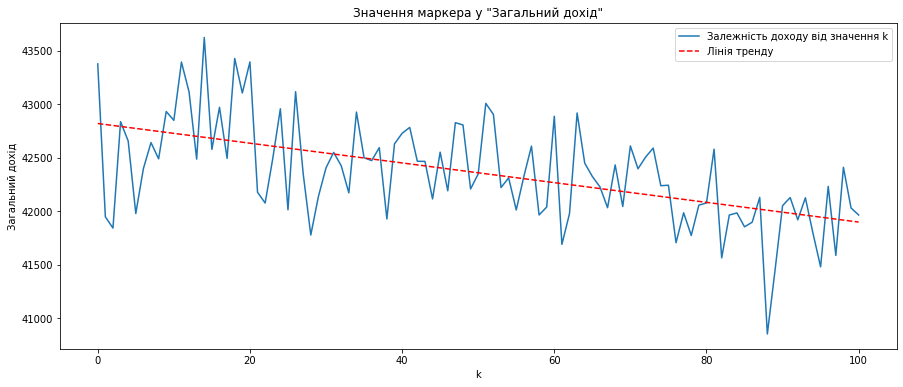

In [10]:
temp = df.sort_values('k', ascending = True)[['k', 'Загальний дохід']].values
x = np.polyfit(temp[:, 0], temp[:, 1], 1)
y = np.poly1d(x)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1], label = 'Залежність доходу від значення k')
ax.plot(temp[:, 0], y(temp[:, 0]), 'r--', label = 'Лінія тренду')
ax.set_xlabel(u'k')
ax.set_ylabel(u'Загальний дохід')
plt.legend()
ax.set_title(u'Значення маркера у "Загальний дохід"')

del temp
df.sort_values('Загальний дохід', ascending = False).to_excel('results/T2-Table-Verification.xlsx', index = False)

### Призначення в переході кожній затримці можливе середнє значення для зменшення стохастичності моделі (запис часу моделювання для кожного переходу при зміні параметру k)

In [11]:
time_queue = []
time_process = []
df_rows = []

time_modeling = 10000.0
ROUND_PARAM = 0

R_list = [9]
T1_list = [7]
T2_list = list(range(200, 301))
T3_list = [2]
T4_list = [70]

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON_list = [0]
T1_DIAPASON_list = [0]
T2_DIAPASON_list = [0]
T4_DIAPASON = [0]
T2_basic = 200

for row in product(T1_list, T1_DIAPASON_list, T2_list, T2_DIAPASON_list, T3_list, T4_list, T4_DIAPASON, R_list, R_DIAPASON_list):
    T1, T1_DIAPASON, T2, T2_DIAPASON_list, T3, T4, T4_DIAPASON, R, R_DIAPASON = row
    k = np.abs(T2_basic - T2)
    
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON,
                          T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3,
                          T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    df_rows.append(dict({'T1': T1, 'T1_DIAPASON': T1_DIAPASON, 
                         'T2': T2, 'T2_DIAPASON': T2_DIAPASON, 
                         'T3': T3,
                         'T4': T4, 'T4_DIAPASON': T4_DIAPASON, 
                         'k': k, 
                         'S1': S1 - S3 * k, 'S2': S2 - S3 * k, 'S3': S3}, **result))
df = pd.DataFrame(df_rows)
df.sort_values('Загальний дохід', ascending = False).head(10)

,T1,T1_DIAPASON,T2,T2_DIAPASON,T3,T4,T4_DIAPASON,k,S1,S2,S3,Загальний дохід,Частота переривань,Доля перерваних повідомлень,Передано основним каналом,Передано резервним каналом
2,7,0,202,35,2,70,0,2,49.94,24.94,0.03,42890.06,0.0032,0.03203,719,280
4,7,0,204,35,2,70,0,4,49.88,24.88,0.03,42830.12,0.0030,0.03003,719,280
11,7,0,211,35,2,70,0,11,49.67,24.67,0.03,42820.33,0.0024,0.02402,727,272
6,7,0,206,35,2,70,0,6,49.82,24.82,0.03,42770.18,0.0031,0.03103,719,280
14,7,0,214,35,2,70,0,14,49.58,24.58,0.03,42730.42,0.0025,0.02503,727,272
1,7,0,201,35,2,70,0,1,49.97,24.97,0.03,42720.03,0.0028,0.02803,711,288
8,7,0,208,35,2,70,0,8,49.76,24.76,0.03,42710.24,0.0027,0.02703,719,280
3,7,0,203,35,2,70,0,3,49.91,24.91,0.03,42710.09,0.0035,0.03504,713,286
22,7,0,222,35,2,70,0,22,49.34,24.34,0.03,42690.66,0.0028,0.02803,735,264
9,7,0,209,35,2,70,0,9,49.73,24.73,0.03,42680.27,0.0032,0.03203,719,280


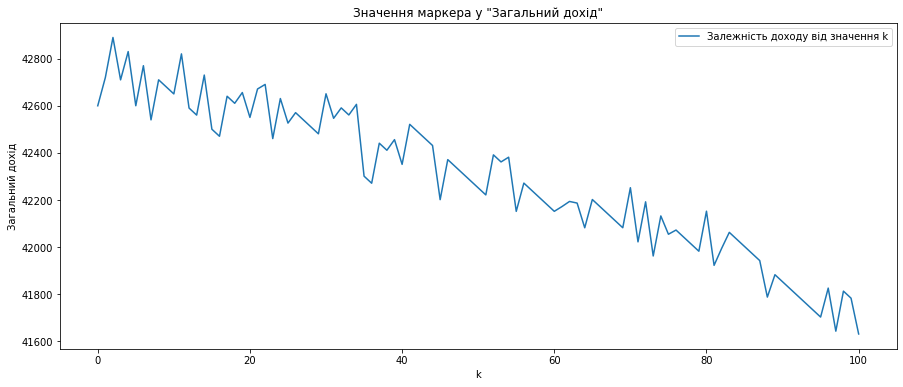

In [12]:
temp = df.sort_values('k', ascending = True)[['k', 'Загальний дохід']].values

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1], label = 'Залежність доходу від значення k')
ax.set_xlabel(u'k')
ax.set_ylabel(u'Загальний дохід')
plt.legend()
ax.set_title(u'Значення маркера у "Загальний дохід"');

del temp
df.sort_values('Загальний дохід', ascending = False).to_excel('results/T2-Table-Verification-consts.xlsx', index = False)

### Перевірка на відтворюваність результату за контрольним експериментом

In [13]:
n_launches = 50
responses_list = []

time_modeling = 10000.0
ROUND_PARAM = 0

R = 9
T1 = 7
T2 = 200
T3 = 2
T4 = 70

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON = 5
T1_DIAPASON = 3
T2_DIAPASON = 35
T4_DIAPASON = 7

T2_basic = 200
k = np.abs(T2_basic - T2)

for launch in range(n_launches):
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON, T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3,
                          T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    responses_list.append(result['Загальний дохід'])

simulation = modeling(time_modeling,
                      is_print_results = False,
                      T1 = T1, T1_DIAPASON = T1_DIAPASON,
                      T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                      T3 = T3,
                      T4 = T4, T4_DIAPASON = T4_DIAPASON,
                      R = R, R_DIAPASON = R_DIAPASON,
                      S1 = S1, S2 = S2, S3 = S3)
result = simulation.launch(is_target_returned = True)
result = result['Загальний дохід']

#### Перевірка чи відрізняється значення відгуку заключного прогону від середнього значення відгуку з 50 прогонів

In [14]:
# Схожість відгуків перевіряється по факту влучання в діапазон
mean_responses = np.mean(responses_list)
std_responses = np.std(responses_list, ddof = 1) # середньоквадратичне (стандартне) відхилення
print(f'mean_responses (µ): {mean_responses}\nstd_responses (σ): {std_responses}\nfinal result (β): {result}\nМетод середніх сум:')
if (mean_responses - std_responses) < result and result < (mean_responses + std_responses):
    print('Система поводиться адекватно.')
else:
    print('Система має проблеми з адекватністю')

mean_responses (µ): 42791.5
std_responses (σ): 494.47482963529814
final result (β): 42825.0
Метод середніх сум:
Система поводиться адекватно.


### Перевірка на відтворюваність результату використовуючи перевірку рівності середніх значень

In [15]:
n_launches = 50
n_final_launches = 3
responses_list = []
responses_final_list = []

time_modeling = 10000.0
ROUND_PARAM = 0

R = 9
T1 = 7
T2 = 200
T3 = 2
T4 = 70

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON = 5
T1_DIAPASON = 3
T2_DIAPASON = 35
T4_DIAPASON = 7

T2_basic = 200
k = np.abs(T2_basic - T2)

for launch in range(n_launches):
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON,
                          T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3, T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    responses_list.append(result['Загальний дохід'])
    
for launch in range(n_final_launches):
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON,
                          T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3, T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    responses_final_list.append(result['Загальний дохід'])

    
alpha = 0.05
stat_val, p_value = st.ttest_ind(responses_list, responses_final_list)
print(f'stat_val: {round(stat_val, 3)}\np_value: {round(p_value, 3)}')
if p_value < alpha:
    print(f'Середні значення вибірок статистично різні')
else:
    print(f'Середні значення вибірок статистично рівні. Можна прийняти гіпотезу про рівність середніх значнь')

stat_val: -0.27
p_value: 0.788
Середні значення вибірок статистично рівні. Можна прийняти гіпотезу про рівність середніх значнь


### Визначення кількості прогонів

In [16]:
n_launches = 50
responses_list = []

time_modeling = 10000.0
ROUND_PARAM = 0

R = 9
T1 = 7
T2 = 200
T3 = 2
T4 = 70

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON = 5
T1_DIAPASON = 3
T2_DIAPASON = 35
T4_DIAPASON = 7

T2_basic = 200
k = np.abs(T2_basic - T2)

for i in range(n_launches):
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON,
                          T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3,
                          T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    responses_list.append(result['Загальний дохід'])

std_responses = np.std(responses_list, ddof = 1)
mean_responses = np.mean(responses_list)

n_launches_p1 = round(((std_responses ** 2) / ((0.01 * mean_responses) ** 2 * (1 - 0.95))) + 1, 1)
n_launches_p2 = round(((1.96 ** 2) * (std_responses ** 2) / ((0.01 * mean_responses) ** 2)) + 1, 1)

print(f'Нерівність Чебишева (p1): {n_launches_p1}')
print(f'Центральна гранична теорема (p2): {n_launches_p2}')

Нерівність Чебишева (p1): 27.6
Центральна гранична теорема (p2): 6.1


### Визначення часу моделюваня

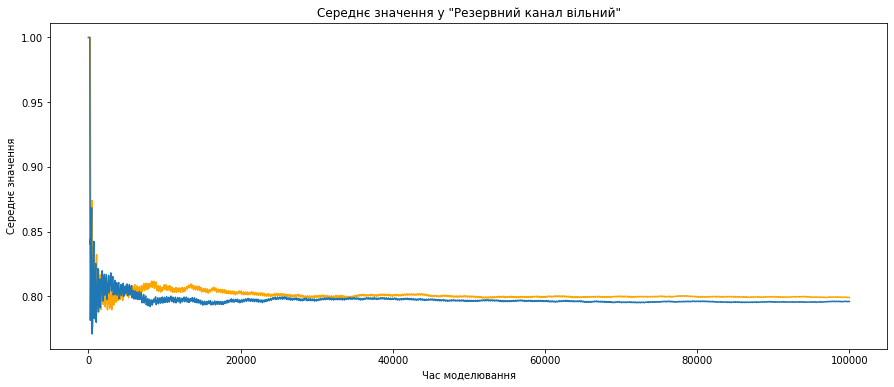

In [17]:
time_queue = []
time_process = []

time_modeling = 100000.0
ROUND_PARAM = 0

R = 9
T1 = 7
T2 = 200
T3 = 2
T4 = 70

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON = 5
T1_DIAPASON = 3
T2_DIAPASON = 35
T4_DIAPASON = 7

T2_basic = 200
k = np.abs(T2_basic - T2)

simulation = modeling(time_modeling,
                      is_print_results = False,
                      T1 = T1, T1_DIAPASON = T1_DIAPASON,
                      T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                      T3 = T3, 
                      T4 = T4, T4_DIAPASON = T4_DIAPASON,
                      R = R, R_DIAPASON = R_DIAPASON,
                      S1 = S1, S2 = S2, S3 = S3)
result1 = simulation.launch(return_markers = 'Резервний канал вільний')

simulation = modeling(time_modeling,
                      is_print_results = False,
                      T1 = T1, T1_DIAPASON = T1_DIAPASON,
                      T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                      T3 = T3,
                      T4 = T4, T4_DIAPASON = T4_DIAPASON,
                      R = R, R_DIAPASON = R_DIAPASON,
                      S1 = S1, S2 = S2, S3 = S3)
result2 = simulation.launch(return_markers = 'Резервний канал вільний')
clear_output()


mean_result1 = []
mean_result2 = []
for i in range(len(result1)):
    mean_result1.append(sum(result1[:i + 1]) / len(result1[:i + 1]))
    mean_result2.append(sum(result2[:i + 1]) / len(result2[:i + 1]))

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(mean_result1, color = 'orange')
ax.plot(mean_result2)
ax.set_xlabel(u'Час моделювання')
ax.set_ylabel(u'Середнє значення')
ax.set_title(u'Середнє значення у "Резервний канал вільний"');

### Факторний аналіз впливу на відгук моделі

In [18]:
n_launches = 28
time_modeling = 30000.0
ROUND_PARAM = 0

df_rows = []
y_launches = []
time_queue = []
time_process = []

R_list = [9]
T1_list = [7]
T2_list = list(range(200, 251, 5))
T3_list = [2] 
T4_list = [70]

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON_list = [5]
T1_DIAPASON_list = [3]
T2_DIAPASON_list = [35]
T4_DIAPASON = [7]
T2_basic = 200

for row in list(product(T1_list, T1_DIAPASON_list, T2_list, T2_DIAPASON_list, T3_list, T4_list, T4_DIAPASON, R_list, R_DIAPASON_list)):
    T1, T1_DIAPASON, T2, T2_DIAPASON, T3, T4, T4_DIAPASON, R, R_DIAPASON = row
    k = np.abs(T2_basic - T2)

    for i in range(n_launches):
        simulation = modeling(time_modeling,
                              is_print_results = False,
                              T1 = T1, T1_DIAPASON = T1_DIAPASON,
                              T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                              T3 = T3, 
                              T4 = T4, T4_DIAPASON = T4_DIAPASON,
                              R = R, R_DIAPASON = R_DIAPASON,
                              S1 = S1, S2 = S2, S3 = S3)
        result = simulation.launch(is_target_returned = True)['Загальний дохід']
        y_launches.append({'k': k, 'target': result})
    clear_output()
df = pd.DataFrame(y_launches)
df.head(10)

,k,target
0,0,128900.0
1,0,129375.0
2,0,128725.0
3,0,128650.0
4,0,128575.0
5,0,128300.0
6,0,127750.0
7,0,127625.0
8,0,129100.0
9,0,128200.0


In [19]:
model = ols('target ~ C(k)', df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     7.517
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.13e-10
Time:                        23:38:50   Log-Likelihood:                -2457.8
No. Observations:                 308   AIC:                             4938.
Df Residuals:                     297   BIC:                             4979.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.283e+05    136.051    943.174      0.0

In [20]:
print(f'Model F({model.df_model: .0f}, {model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}')

anova_results = sm.stats.anova_lm(model, typ = 2)
anova_results

Model F( 10,  297) =  7.517, p =  0.0000


,sum_sq,df,F,PR(>F)
C(k),3.895794e+07,10.0,7.516836,1.130918e-10
Residual,1.539279e+08,297.0,NaN,NaN


### Визначення закону розподілу часу передачі повідомлень по магістралі

In [21]:
time_queue = []
time_process = []

time_modeling = 50000.0
ROUND_PARAM = 0

R = 9
T1 = 7
T2 = 200
T3 = 2
T4 = 70

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON = 5
T1_DIAPASON = 3
T2_DIAPASON = 35
T4_DIAPASON = 7

T2_basic = 200
k = np.abs(T2_basic - T2)

simulation = modeling(time_modeling,
                      is_print_results = False,
                      T1 = T1, T1_DIAPASON = T1_DIAPASON,
                      T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                      T3 = T3,
                      T4 = T4, T4_DIAPASON = T4_DIAPASON,
                      R = R, R_DIAPASON = R_DIAPASON,
                      S1 = S1, S2 = S2, S3 = S3)
result = simulation.launch(is_target_returned = False)

Час моделювання - 50000.0


,info,min_markers,max_markers,avg_markers,result_markers
0,Поступлення повідомлення,0,1.0,0.10006,0.0
1,Загальний накопичувач,0,4.0,0.31174,0.0
2,Основний канал вільний,0,1.0,0.48218,1.0
3,Резервний канал вільний,0,1.0,0.79646,1.0
4,Буфер,0,1.0,0.07416,0.0
5,Кількість переривань,0,155.0,77.22502,155.0
6,Дохід через основний канал,0,177650.0,88457.16400,177650.0
7,Передано основним каналом,0,3553.0,1769.14328,3553.0
8,Загальний дохід,0,213900.0,106503.12300,213900.0
9,Кількість переданих повідомлень,0,5003.0,2490.98164,5003.0


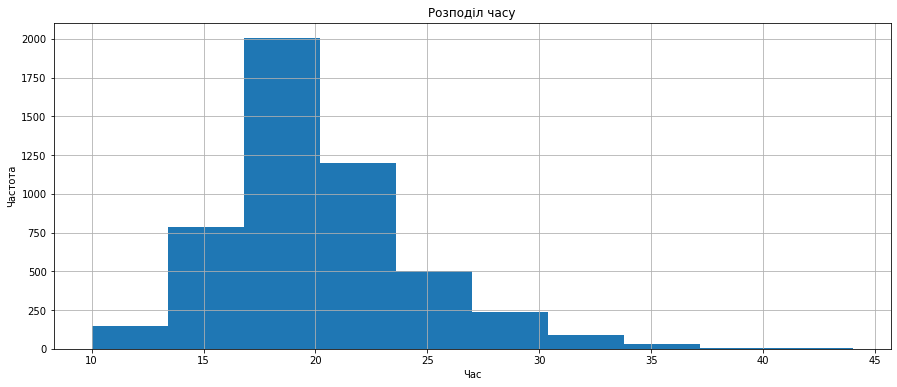

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.hist(time_process)
ax.grid(True)
ax.set_xlabel(u'Час')
ax.set_ylabel(u'Частота')
ax.set_title(u'Розподіл часу')
plt.show()

In [23]:
def normilize_uniform_bins(observed_frequency, expected_frequency, n_min = 100):
    assert len(observed_frequency) > 2 or len(expected_frequency) > 2
    for i in sorted(observed_frequency.keys(), reverse = True)[:-1]:
        if observed_frequency[i] <= n_min or expected_frequency[i] <= n_min:
            observed_frequency[i-1] += observed_frequency[i]
            expected_frequency[i-1] += expected_frequency[i]
            del observed_frequency[i], expected_frequency[i]
    for i in sorted(observed_frequency.keys())[:-1]:
        if observed_frequency[i] <= n_min or expected_frequency[i] <= n_min:
            j = 1
            while not i + j in observed_frequency:
                j += 1
            observed_frequency[i+j] += observed_frequency[i]
            expected_frequency[i+j] += expected_frequency[i]
            del observed_frequency[i], expected_frequency[i]
    return observed_frequency, expected_frequency

def create_uniform_bins(x, a, b, n_bins = 30, n_min = 20):
    observed_frequency = {}
    expected_frequency = {}
    start = x.min()
    end = x.max() + 1e-9
    n = x.size
    h = (end - start) / n_bins
    curr = start
    i = 0
    while curr <= end:
        observed_frequency[i] = np.sum((x >= curr) & (x < (curr+h)))
        p_i = np.abs(st.uniform(a, b).cdf(curr) - st.uniform(a, b).cdf(curr + h))
        expected_frequency[i] = p_i * n
        i += 1
        curr += h
    return normilize_uniform_bins(observed_frequency, expected_frequency, n_min = n_min)


time_process = np.array(time_process)
print(f'Max Time Process: {time_process.max()}')
x = np.linspace(0, time_process.max(), 1000000)
b = (x.mean() + np.sqrt(3) * x.std(ddof = 1))
a = 2 * x.mean() - b
observed_freq, expected_freq = create_uniform_bins(time_process, a, b, n_bins = 10, n_min = 200)
print(f'a: {a}\nb: {b}')

alpha = 0.05
stat_val, p_value = st.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof = 2)
print(f'stat_val: {round(stat_val, 3)}\np_value: {round(p_value, 3)}')
if p_value < alpha:
    print(f'Не можна прийняти нульову гіпотезу на рівні значимості alpha = {alpha}')
else:
    print('Можна прийняти нульову гіпотезу про розподіл данних з заданим параметром')

Max Time Process: 44.0
a: -3.300003024264697e-05
b: 44.000033000030236
stat_val: 10013.961
p_value: 0.0
Не можна прийняти нульову гіпотезу на рівні значимості alpha = 0.05


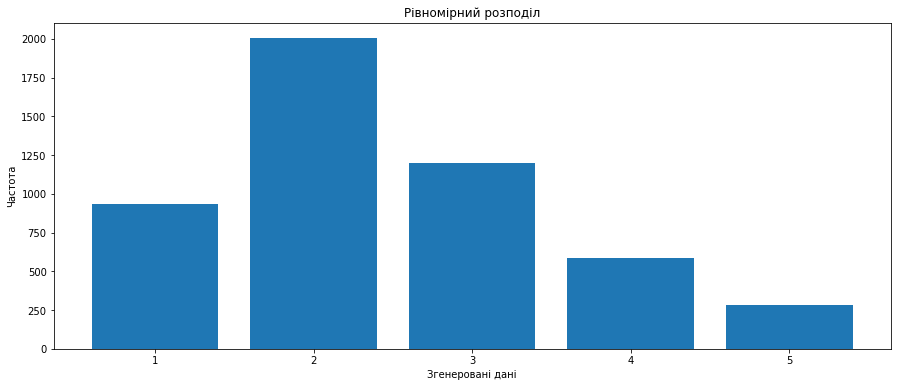

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.bar(x = list(observed_freq.keys()), height = list(observed_freq.values()))
ax.set_xlabel(u'Згенеровані дані')
ax.set_ylabel(u'Частота')
ax.set_title(u'Рівномірний розподіл');

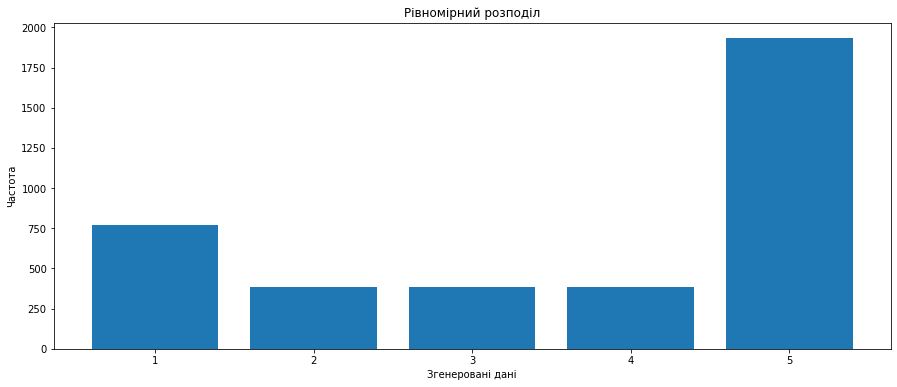

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.bar(x = list(expected_freq.keys()), height = list(expected_freq.values()))
ax.set_xlabel(u'Згенеровані дані')
ax.set_ylabel(u'Частота')
ax.set_title(u'Рівномірний розподіл');

In [26]:
def choose_perfect_distribution(times):
    results = []
    params = {}
    names = ['dweibull', 'expon', 'norm', 'uniform']
    for name in names:
        dist = getattr(st, name)
        param = dist.fit(times)
        params[name] = param
        D, p = st.kstest(times, name, args = param)
        print(f'{name} distribution p_value: {str(p)}')
        results.append((name, p))
    perfect_distribution, perfect_p = (max(results, key=lambda item: item[1]))
    print(f'\nPerfect distribution: {str(perfect_distribution)}')
    print(f'Perfect p_value: {str(perfect_p)}')
    print(f'Params: {str(params[perfect_distribution])}')
    return perfect_distribution, perfect_p, params[perfect_distribution]

perfect_distribution, p_value, params = choose_perfect_distribution(time_process)

alpha = 0.05
print(f'stat_val: {round(stat_val, 3)}\np_value: {round(p_value, 3)}')
if p_value < alpha:
    print(f'\nНе можна прийняти нульову гіпотезу на рівні значемості alpha = {alpha}')
else:
    print('Можна прийняти нульову гіпотезу про розподіл данних з заданим параметром')
    print(f'Найкращий розподіл: {perfect_distribution}')
    print(f'Params: {params}')
    print(f'p_value: {round(p_value, 3)}')

dweibull distribution p_value: 1.9393305817681117e-19
expon distribution p_value: 0.0
norm distribution p_value: 2.864981596948623e-43
uniform distribution p_value: 0.0

Perfect distribution: dweibull
Perfect p_value: 1.9393305817681117e-19
Params: (1.2310466729236302, 19.576704608688075, 3.438291066492069)
stat_val: 10013.961
p_value: 0.0

Не можна прийняти нульову гіпотезу на рівні значемості alpha = 0.05


### Визначення завантаження основного та резервного каналу

In [27]:
df_rows = []
time_queue = []
time_process = []

time_modeling = 30000.0
ROUND_PARAM = 0

R_list = [9]
T1_list = [7]
T2_list = list(range(200, 501, 25))
T3_list = [2]
T4_list = [70]

S1 = 50
S2 = 25
S3 = 0.03

R_DIAPASON_list = [0]
T1_DIAPASON_list = [0]
T2_DIAPASON_list = [0]
T4_DIAPASON = [0]
T2_basic = 200

for row in product(T1_list, T1_DIAPASON_list, T2_list, T2_DIAPASON_list, T3_list, T4_list, T4_DIAPASON, R_list, R_DIAPASON_list):
    T1, T1_DIAPASON, T2, T2_DIAPASON, T3, T4, T4_DIAPASON, R, R_DIAPASON = row
    k = np.abs(T2_basic - T2)
    
    simulation = modeling(time_modeling,
                          is_print_results = False,
                          T1 = T1, T1_DIAPASON = T1_DIAPASON,
                          T2 = T2, T2_DIAPASON = T2_DIAPASON, T2_basic = T2_basic,
                          T3 = T3,
                          T4 = T4, T4_DIAPASON = T4_DIAPASON,
                          R = R, R_DIAPASON = R_DIAPASON,
                          S1 = S1, S2 = S2, S3 = S3)
    result = simulation.launch(is_target_returned = True)
    df_rows.append(dict({'T1': T1, 'T1_DIAPASON': T1_DIAPASON,
                         'T2': T2, 'T2_DIAPASON': T2_DIAPASON,
                         'T3': T3,
                         'T4': T4, 'T4_DIAPASON': T4_DIAPASON,
                         'k': k,
                         'S1': S1 - S3 * k, 'S2': S2 - S3 * k, 'S3': S3,
                         'modeling_time': time_modeling}, **result))
    
df = pd.DataFrame(df_rows)
df.head(10)

,T1,T1_DIAPASON,T2,T2_DIAPASON,T3,T4,T4_DIAPASON,k,S1,S2,S3,modeling_time,Загальний дохід,Частота переривань,Доля перерваних повідомлень,Передано основним каналом,Передано резервним каналом
0,7,0,200,0,2,70,0,0,50.00,25.00,0.03,30000.0,128100.00,0.00247,0.02468,2126,872
1,7,0,225,0,2,70,0,25,49.25,24.25,0.03,30000.0,127700.75,0.00290,0.02901,2199,800
2,7,0,250,0,2,70,0,50,48.50,23.50,0.03,30000.0,127003.00,0.00213,0.02135,2262,736
3,7,0,275,0,2,70,0,75,47.75,22.75,0.03,30000.0,126002.25,0.00267,0.02668,2311,688
4,7,0,300,0,2,70,0,100,47.00,22.00,0.03,30000.0,124953.00,0.00180,0.01801,2359,640
5,7,0,325,0,2,70,0,125,46.25,21.25,0.03,30000.0,123703.75,0.00233,0.02334,2399,600
6,7,0,350,0,2,70,0,150,45.50,20.50,0.03,30000.0,122384.00,0.00163,0.01634,2437,561
7,7,0,375,0,2,70,0,175,44.75,19.75,0.03,30000.0,120855.25,0.00210,0.02101,2465,534
8,7,0,400,0,2,70,0,200,44.00,19.00,0.03,30000.0,119356.00,0.00143,0.01434,2495,504
9,7,0,425,0,2,70,0,225,43.25,18.25,0.03,30000.0,117706.75,0.00183,0.01834,2519,480


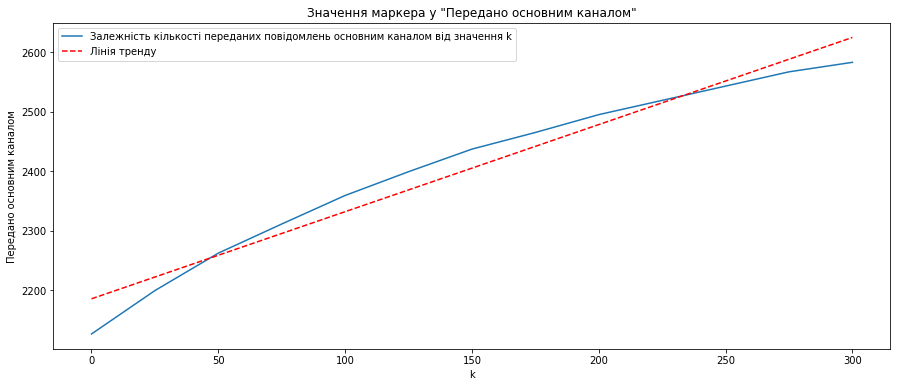

In [28]:
temp = df.sort_values('k', ascending = True)[['k', 'Передано основним каналом']].values
z = np.polyfit(temp[:, 0], temp[:, 1], 1)
p = np.poly1d(z)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1], label = 'Залежність кількості переданих повідомлень основним каналом від значення k')
ax.plot(temp[:, 0], p(temp[:, 0]), 'r--', label = 'Лінія тренду')
ax.set_xlabel(u'k')
ax.set_ylabel(u'Передано основним каналом')
plt.legend()
ax.set_title(u'Значення маркера у "Передано основним каналом"');

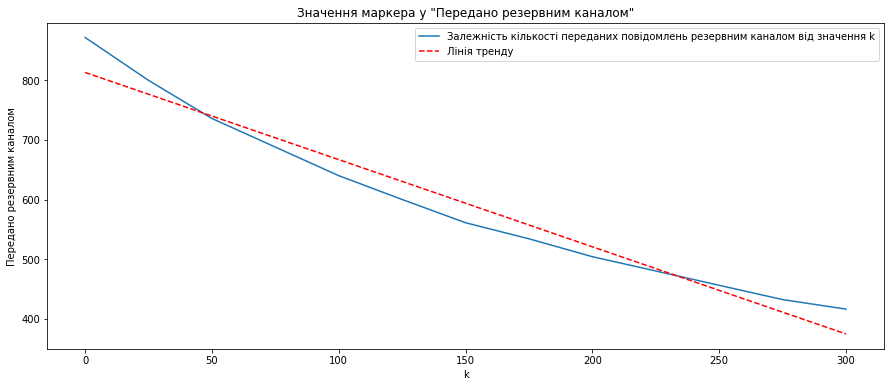

In [29]:
temp = df.sort_values('k', ascending = True)[['k', 'Передано резервним каналом']].values
z = np.polyfit(temp[:, 0], temp[:, 1], 1)
p = np.poly1d(z)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1], label = 'Залежність кількості переданих повідомлень резервним каналом від значення k')
ax.plot(temp[:, 0], p(temp[:, 0]), 'r--', label = 'Лінія тренду')
ax.set_xlabel(u'k')
ax.set_ylabel(u'Передано резервним каналом')
plt.legend()
ax.set_title(u'Значення маркера у "Передано резервним каналом"');

### Визначення частоти переривань

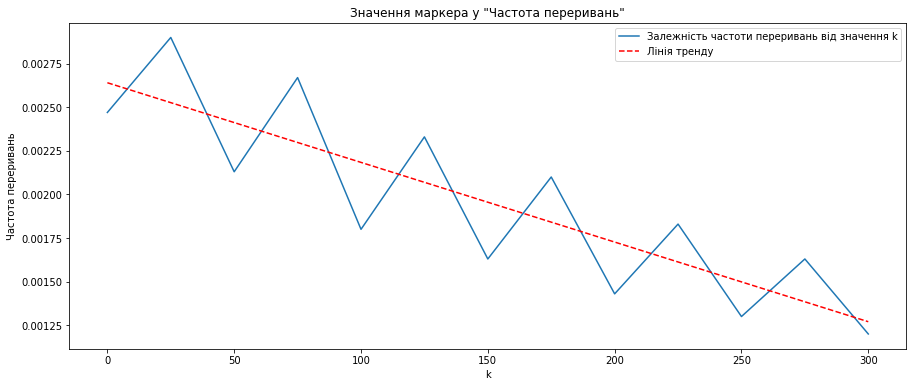

In [30]:
temp = df.sort_values('k', ascending = True)[['k', 'Частота переривань']].values
x = np.polyfit(temp[:, 0], temp[:, 1], 1)
y = np.poly1d(x)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1], label = 'Залежність частоти переривань від значення k')
ax.plot(temp[:, 0], y(temp[:, 0]), 'r--', label = 'Лінія тренду')
ax.set_xlabel(u'k')
ax.set_ylabel(u'Частота переривань')
plt.legend()
ax.set_title(u'Значення маркера у "Частота переривань"');

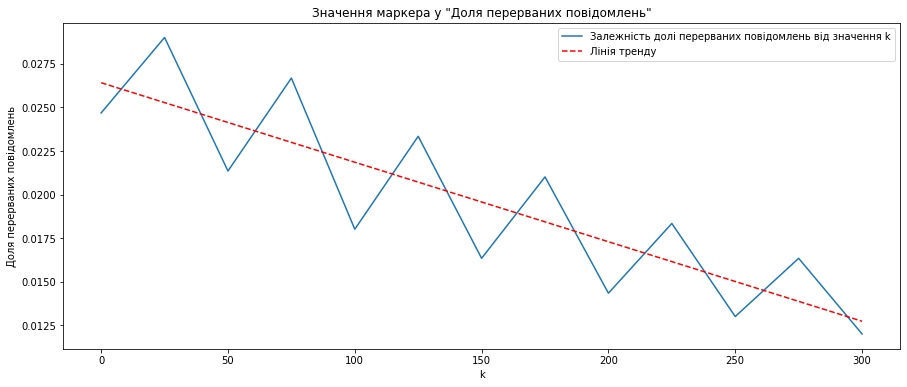

In [31]:
temp = df.sort_values('k', ascending = True)[['k', 'Доля перерваних повідомлень']].values
x = np.polyfit(temp[:, 0], temp[:, 1], 1)
y = np.poly1d(x)

fig, ax = plt.subplots(1,1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1], label = 'Залежність долі перерваних повідомлень від значення k')
ax.plot(temp[:, 0], y(temp[:, 0]), 'r--', label = 'Лінія тренду')
ax.set_xlabel(u'k')
ax.set_ylabel(u'Доля перерваних повідомлень')
plt.legend()
ax.set_title(u'Значення маркера у "Доля перерваних повідомлень"');